In [189]:
%load_ext autoreload
%autoreload 2
from pileup_image.pileup import pileup_images, parse_insertion
from pileup_image.utils import plot_images
import torch
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
LOG = logging.getLogger("Train")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
parse_insertion('A+2N')

ValueError('Insertion base is wrong: A+2N')

In [184]:
contig, start, stop = "chr10",7771994,7772033

genomic_img = pileup_images(
    bam_fn='/Users/wckdouglas/Desktop/subsampled.bam',
    ref_fa_fn="/Users/wckdouglas/Desktop/chr10.fa.gz",
    contig=contig,
    start=start,
    stop=stop,
)

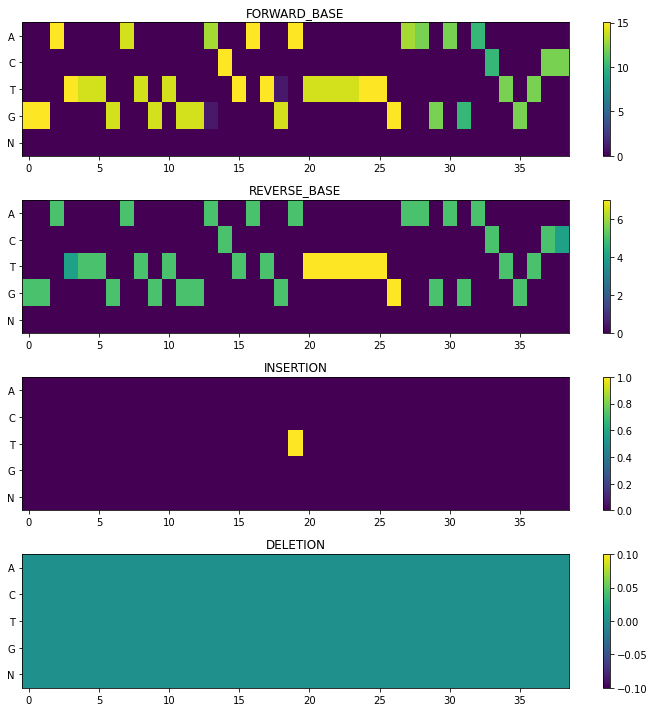

In [188]:
fig = plot_images(genomic_img)

In [124]:
data_set = []
ys = []

for i in range(10000):
    if i % 2 == 0:
        mut_img = np.random.normal(size= np.product(genomic_img.shape))
        mut_img = mut_img.reshape(genomic_img.shape)
        data_set.append(mut_img)
    else:
        data_img = genomic_img.copy()
        data_img[1,:,:] = data_img[1,:,:] + np.random.normal(loc=10, size=np.product(genomic_img[0].shape)).reshape(genomic_img[1].shape)
        data_set.append(genomic_img)
    ys.append(i % 2)
data_set=np.array(data_set)
ys=np.array(ys)

In [131]:
class PseudoSlayClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        base_window_size = 20
        base_move_step = 2
        
        self.conv_layer = torch.nn.Conv2d(
            in_channels=4,
            out_channels=1,
            kernel_size=(5, base_window_size), # scanning 200bp and all 50 reads at a time
            stride=base_move_step, # moving 20bp at a time
        )
        self.max_pool = torch.nn.MaxPool2d(kernel_size = (1, 4)) # taking 10 best features
        self.drop_out = torch.nn.Dropout(p=0.2)
        self.linear = torch.nn.Linear(2, 1)
        
        # set up model
        self.model = torch.nn.Sequential(
            self.conv_layer,
            torch.nn.ReLU(),
            self.max_pool,
            self.drop_out,
            self.linear,
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        return self.model(x)

In [132]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def calculate_metrics(y, pred_y, epoch, loss):
    '''
    Output some metrics
    '''
    pred_label = pred_y.detach().numpy().round()
    accuracy = accuracy_score(y, pred_label)
    precision = precision_score(y, pred_label)
    recall = recall_score(y, pred_label)
    f1 = f1_score(y, pred_label)
    LOG.info(
        'Mini-batch: %.3f Loss: %.3f Accuracy: %.3f'
        ' F1: %.3f Precision %.3f Recall %.3f', 
        epoch, 
        loss, 
        accuracy, 
        f1, 
        precision, 
        recall
    )
    


model = PseudoSlayClassifier()
optimizer = torch.optim.Adam(model.parameters(), 
                          lr = 0.001)

In [133]:
losses = []
steps=10000
for step in range(steps):
    optimizer.zero_grad()

    # get data
    idx = np.random.randint(0,500, size=100)
    X = torch.Tensor(data_set[idx])
    y = torch.Tensor(ys[idx])

    #get prediction (forward)
    pred_y = model(X)
    pred_y = pred_y.view(-1)
    #assert sum(pred_y != pred_y).item() == 0, pred_y
    loss = torch.nn.functional.binary_cross_entropy(pred_y, y)
    losses.append(loss.detach().numpy())

    # update gradient
    loss.backward()
    optimizer.step()
    if step % 1000 == 0:
        calculate_metrics(y.detach().numpy(), pred_y, epoch=step, loss=float(loss.detach().numpy()) )

INFO:Train:Mini-batch: 0.000 Loss: 0.933 Accuracy: 0.280 F1: 0.265 Precision 0.250 Recall 0.283
INFO:Train:Mini-batch: 1000.000 Loss: 0.142 Accuracy: 0.920 F1: 0.913 Precision 0.840 Recall 1.000
INFO:Train:Mini-batch: 2000.000 Loss: 0.126 Accuracy: 0.880 F1: 0.864 Precision 0.864 Recall 0.864
INFO:Train:Mini-batch: 3000.000 Loss: 0.149 Accuracy: 0.840 F1: 0.840 Precision 0.894 Recall 0.792
INFO:Train:Mini-batch: 4000.000 Loss: 0.148 Accuracy: 0.830 F1: 0.821 Precision 0.867 Recall 0.780
INFO:Train:Mini-batch: 5000.000 Loss: 0.168 Accuracy: 0.820 F1: 0.795 Precision 0.778 Recall 0.814
INFO:Train:Mini-batch: 6000.000 Loss: 0.143 Accuracy: 0.870 F1: 0.860 Precision 0.909 Recall 0.816
INFO:Train:Mini-batch: 7000.000 Loss: 0.130 Accuracy: 0.850 F1: 0.848 Precision 0.894 Recall 0.808
INFO:Train:Mini-batch: 8000.000 Loss: 0.121 Accuracy: 0.870 F1: 0.860 Precision 0.976 Recall 0.769
INFO:Train:Mini-batch: 9000.000 Loss: 0.143 Accuracy: 0.830 F1: 0.773 Precision 0.879 Recall 0.690


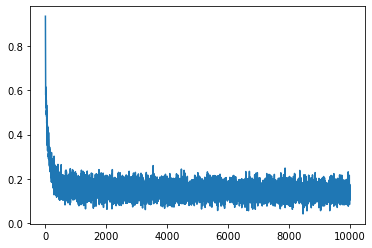

In [134]:
plt.plot(losses)

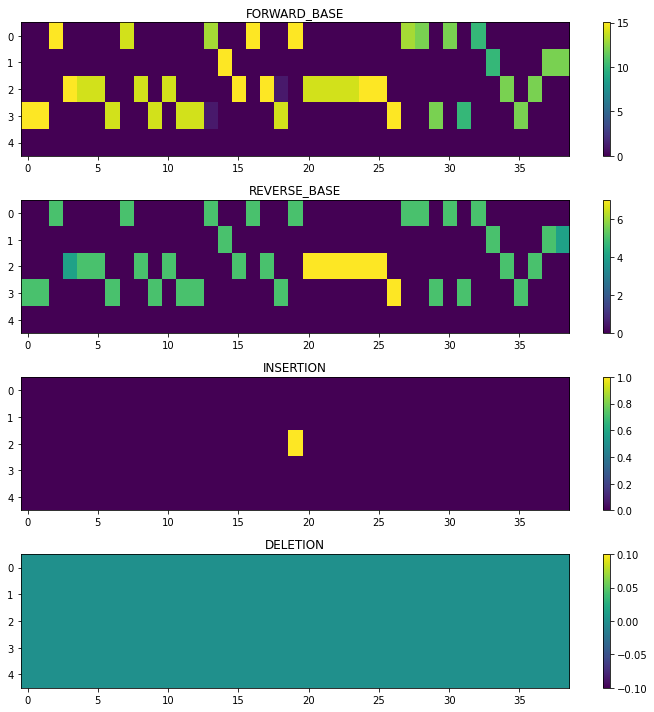

In [176]:
fig = plot_images(genomic_img)
fig.savefig("pileup.png", bbox_inches='tight')

In [154]:
prediction = np.round(pred_y.detach().numpy())

In [162]:
np.where(y.detach().numpy() != prediction)

(array([ 6, 15, 31, 60, 70, 72, 81, 95]),)

In [174]:
i = 6
y[i], pred_y[i]

(tensor(1.), tensor(0.4986, grad_fn=<SelectBackward0>))

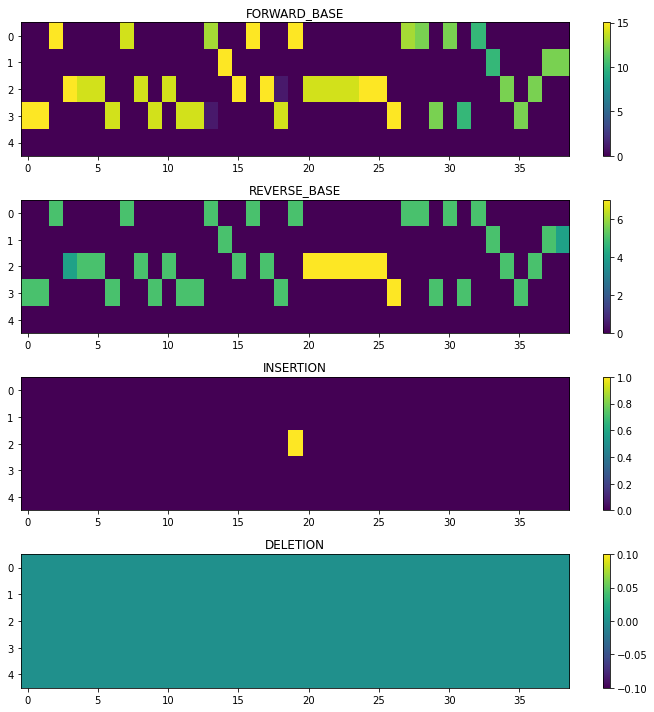

In [175]:
fig = plot_images(X[i])